In [1]:
## Packages
##Imports
import pandas as pd
import transformers
import openpyxl
import numpy
import torch
import os
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import time

import torch
import torch.nn as nn

# Does augmenting classifiers with structured data help?
# Do it for both the baseline classical ML and transformers then compare
# Try it with just structured data [0s and 1s]

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


In [5]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# category_mapping = df['drug_name'].astype('category').cat.categories

In [8]:
# code_to_drug = {code: drug for code, drug in enumerate(category_mapping)}
# print(code_to_drug)

In [9]:
def transform_labels(row):
    labels = [
        '[POS] adverse drug reaction' if row['ADR'] == 1 else '[NEG] adverse drug reaction',
        '[POS] withdrawal symptom' if row['WD'] == 1 else '[NEG] withdrawal symptom',
        '[POS] effective' if row['EF'] == 1 else '[NEG] effective',
        '[POS] ineffective' if row['INF'] == 1 else '[NEG] ineffective',
        '[POS] sign/symptom/illness' if row['SSI'] == 1 else '[NEG] sign/symptom/illness',
        '[POS] drug indication' if row['DI'] == 1 else '[NEG] drug indication'
    ]
    return ' '.join(labels)

# df['drug_name'] = df['drug_name'].astype('category').cat.codes

In [10]:
# category_mapping = df['drug_name'].astype('category').cat.categories
# print(category_mapping)

In [11]:
#this one is for the combined sentences -- Task 2 Feature 1

df_word_label = df

df_word_label['transformed_sentences'] = df.apply(lambda row: f"{row['sentences']} {transform_labels(row)}", axis=1)
#print(df_word_label)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption
df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","sentences", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1, inplace=True)

df_word_label = df_word_label[['transformed_sentences', 'drug_name']]

df_train, df_test = train_test_split(df_word_label, random_state=42, test_size=0.10, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_word_label, random_state=42, test_size=0.50, shuffle=True)

In [12]:
# # ## This one is just for the text without transformed sentences -- Task 2 Feature 2
# df_word_label=df


# # x = df_word_label['sentences'].values
# # y = df_word_label['drug_name'].astype('category').cat.codes.values
# df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1, inplace=True)
# df_word_label = df_word_label[['sentences', 'drug_name']]

# # Split data
# df_train, df_test = train_test_split(df_word_label, random_state=42, test_size=0.10, shuffle=True)
# # split test into test and validation datasets
# df_test, df_valid = train_test_split(df_word_label, random_state=42, test_size=0.50, shuffle=True)

In [13]:
# ## This one is just for the annotated dataset -- Task 2 Feature 3

# df_word_label = df

# df_word_label['transformed_labels'] = df_word_label.apply(transform_labels, axis=1)
# print(df_word_label['transformed_labels'])

# df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","sentences", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1, inplace=True)
# df_word_label = df_word_label[['transformed_labels', 'drug_name']]

# # x = df_word_label['transformed_labels'].values
# # y = df_word_label['drug_name'].astype('category').cat.codes.values

# #Split data
# df_train, df_test = train_test_split(df_word_label, random_state=42, test_size=0.10, shuffle=True)
# # split test into test and validation datasets
# df_test, df_valid = train_test_split(df_word_label, random_state=42, test_size=0.50, shuffle=True)

In [14]:
print(df_word_label)

                                  transformed_sentences  drug_name
0     extreme weight gain short-term memory loss hai...    lexapro
1     detoxing lexapro [NEG] adverse drug reaction [...    lexapro
2     slowly cut dosage several months took vitamin ...    lexapro
3     10 days completely omg rough [NEG] adverse dru...    lexapro
4     flu-like symptoms dizziness major mood swings ...    lexapro
...                                                 ...        ...
6004  increase dosage yet [NEG] adverse drug reactio...  effexorxr
6005  'm hoping able stay 75 mgs long possible [NEG]...  effexorxr
6006  reading withdrawals little scarey like said pe...  effexorxr
6007  effexor made huge difference life come experie...  effexorxr
6008  would small price pay able enjoy life [NEG] ad...  effexorxr

[6009 rows x 2 columns]


In [15]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (5408, 2), Test: (3004, 2), Valid: (3005, 2)


In [16]:
from transformers import BertTokenizer


In [17]:
print(df['drug_name'].unique().tolist())

['lexapro', 'zoloft', 'cymbalta', 'effexorxr']


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'lexapro':0,
          'zoloft':1,
          'cymbalta':2,
          'effexorxr':3
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['drug_name']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['transformed_sentences']]
                                ## change the df[''] depending on the feature

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [20]:
from torch.optim import Adam
from tqdm import tqdm

In [21]:
import os
from collections import defaultdict
import time

history = defaultdict(list)
torch.cuda.empty_cache()
def train(model, train_data, val_data, learning_rate, epochs, model_save_path):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    best_accuracy = 0

    start_time = time.time()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
        
        train_acc = total_acc_train / len(train_data)
        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            if not os.path.exists(model_save_path):
                os.makedirs(model_save_path)
            torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.bin'))
            print(f"Model saved to {model_save_path}")
            best_accuracy = val_acc
        
        print(f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} | Train Accuracy: {train_acc: .3f} | Val Loss: {val_loss: .3f} | Val Accuracy: {val_acc: .3f}')

    end_time = time.time()
    total_train_time = end_time - start_time

    print(f"Total training time: {total_train_time:.2f} seconds")
    torch.cuda.empty_cache()
    return history

EPOCHS = 20
model = BertClassifier()
LR = 1e-6
model_save_path = './model2_task2_feature1_model(unfrozen)'

train(model, df_train, df_valid, LR, EPOCHS, model_save_path)
torch.cuda.empty_cache()

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 2704/2704 [04:45<00:00,  9.48it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 1 | Train Loss:  0.791 | Train Accuracy:  0.263 | Val Loss:  0.769 | Val Accuracy:  0.261


100%|██████████| 2704/2704 [06:39<00:00,  6.76it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 2 | Train Loss:  0.733 | Train Accuracy:  0.290 | Val Loss:  0.699 | Val Accuracy:  0.334


100%|██████████| 2704/2704 [06:37<00:00,  6.80it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 3 | Train Loss:  0.680 | Train Accuracy:  0.363 | Val Loss:  0.657 | Val Accuracy:  0.389


100%|██████████| 2704/2704 [07:02<00:00,  6.40it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 4 | Train Loss:  0.644 | Train Accuracy:  0.411 | Val Loss:  0.629 | Val Accuracy:  0.424


100%|██████████| 2704/2704 [06:56<00:00,  6.49it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 5 | Train Loss:  0.604 | Train Accuracy:  0.471 | Val Loss:  0.583 | Val Accuracy:  0.505


100%|██████████| 2704/2704 [06:32<00:00,  6.88it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 6 | Train Loss:  0.548 | Train Accuracy:  0.562 | Val Loss:  0.526 | Val Accuracy:  0.602


100%|██████████| 2704/2704 [06:41<00:00,  6.73it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 7 | Train Loss:  0.470 | Train Accuracy:  0.652 | Val Loss:  0.458 | Val Accuracy:  0.665


100%|██████████| 2704/2704 [04:44<00:00,  9.52it/s]


Model saved to ./model2_task2_feature1_model(unfrozen)
Epochs: 8 | Train Loss:  0.378 | Train Accuracy:  0.756 | Val Loss:  0.390 | Val Accuracy:  0.753


100%|██████████| 2704/2704 [04:40<00:00,  9.63it/s]


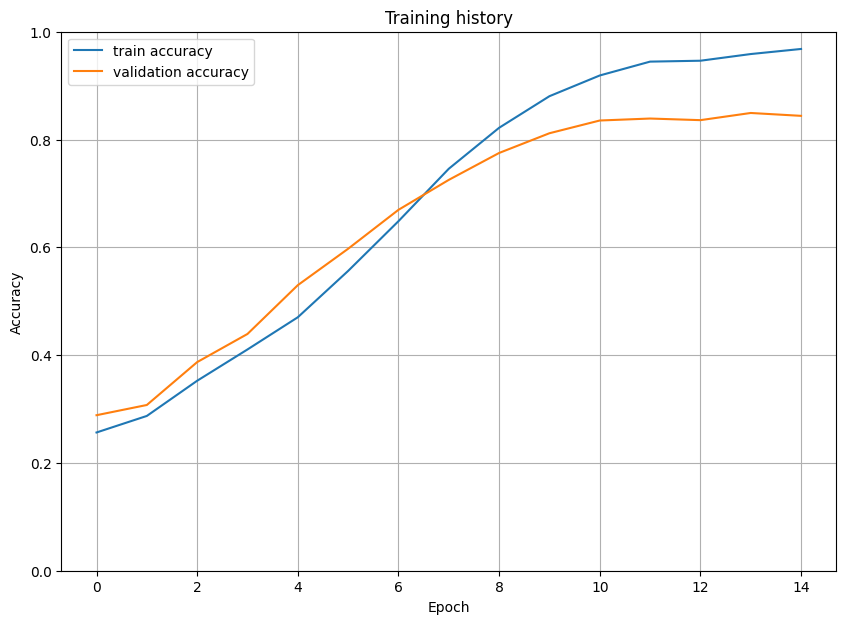

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [ ]:
# Loading pretrained model (best model)
model_load_path = './model2_task2_feature1_model(unfrozen)'
model = BertClassifier()
model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
model = model.to(device)

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
test_data_loader = torch.utils.data.DataLoader(df_test, batch_size=8, shuffle=False)


In [ ]:
torch.cuda.empty_cache()
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    total_acc_test = 0
    total_loss_test = 0
    model.eval()

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader, desc="Evaluating"):
            test_label = test_label.to(device, dtype=torch.long)  # Ensure labels are of type long
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            loss = criterion(output, test_label)
            total_loss_test += loss.item()

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    avg_loss_test = total_loss_test / len(test_dataloader)
    avg_acc_test = total_acc_test / len(test_data)

    print(f'Test Loss: {avg_loss_test:.3f} | Test Accuracy: {avg_acc_test:.3f}')
evaluate(model, df_test)

# labels = {'lexapro':0,
#           'zoloft':1,
#           'cymbalta':2,
#           'effexorxr':3
#           }

Evaluating: 100%|██████████| 1502/1502 [00:48<00:00, 31.23it/s]

Test Loss: 0.128 | Test Accuracy: 0.975


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def get_prediction(model, dataloader):
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if use_cuda else torch.device('cpu')

    if use_cuda:
        model = model.cuda()

    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for data_input, data_label in tqdm(dataloader):
            data_label = data_label.to(device)
            mask = data_input['attention_mask'].squeeze(1).to(device)
            input_id = data_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            preds = output.argmax(dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(data_label.cpu().numpy())

    return predictions, true_labels

# Example usage
# Assuming df_test is a DataFrame containing test data with columns 'drug_name' and 'transformed_sentences'
test_dataset = Dataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Load the best saved model
model.load_state_dict(torch.load(os.path.join(model_save_path, 'model_state.bin')))

# Get predictions
predictions, true_labels = get_prediction(model, test_dataloader)

# You can then compare the predictions with the true labels or use them for further evaluation
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions))

100%|██████████| 1502/1502 [00:48<00:00, 31.03it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       720
           1       0.99      0.93      0.96       632
           2       0.98      0.98      0.98       871
           3       0.95      0.99      0.97       781

    accuracy                           0.98      3004
   macro avg       0.98      0.97      0.97      3004
weighted avg       0.98      0.98      0.97      3004



## Feature 2

In [ ]:
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

# ## This one is just for the text without transformed sentences -- Task 2 Feature 2
df_word_label=df


# x = df_word_label['sentences'].values
# y = df_word_label['drug_name'].astype('category').cat.codes.values
df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1, inplace=True)
df_word_label = df_word_label[['sentences', 'drug_name']]

# Split data
df_train, df_test = train_test_split(df_word_label, random_state=42, test_size=0.10, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_word_label, random_state=42, test_size=0.50, shuffle=True)

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'lexapro':0,
          'zoloft':1,
          'cymbalta':2,
          'effexorxr':3
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['drug_name']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['sentences']]
                                ## change the df[''] depending on the feature

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
import os
from collections import defaultdict
import time

history = defaultdict(list)
torch.cuda.empty_cache()
def train(model, train_data, val_data, learning_rate, epochs, model_save_path):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    best_accuracy = 0

    start_time = time.time()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
        
        train_acc = total_acc_train / len(train_data)
        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            if not os.path.exists(model_save_path):
                os.makedirs(model_save_path)
            torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.bin'))
            print(f"Model saved to {model_save_path}")
            best_accuracy = val_acc
        
        print(f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} | Train Accuracy: {train_acc: .3f} | Val Loss: {val_loss: .3f} | Val Accuracy: {val_acc: .3f}')

    end_time = time.time()
    total_train_time = end_time - start_time

    print(f"Total training time: {total_train_time:.2f} seconds")
    torch.cuda.empty_cache()
    return history

EPOCHS = 20
model = BertClassifier()
LR = 1e-6
model_save_path = './model2_task2_feature2_model(unfrozen)'

train(model, df_train, df_valid, LR, EPOCHS, model_save_path)
torch.cuda.empty_cache()

  0%|          | 2/2704 [00:10<3:46:42,  5.03s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [ ]:
# Loading pretrained model (best model)
model_load_path = './model2_task2_feature2_model(unfrozen)'
model = BertClassifier()
model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
model = model.to(device)

In [ ]:
test_data_loader = torch.utils.data.DataLoader(df_test, batch_size=8, shuffle=False)


In [ ]:
torch.cuda.empty_cache()
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    total_acc_test = 0
    total_loss_test = 0
    model.eval()

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader, desc="Evaluating"):
            test_label = test_label.to(device, dtype=torch.long)  # Ensure labels are of type long
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            loss = criterion(output, test_label)
            total_loss_test += loss.item()

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    avg_loss_test = total_loss_test / len(test_dataloader)
    avg_acc_test = total_acc_test / len(test_data)

    print(f'Test Loss: {avg_loss_test:.3f} | Test Accuracy: {avg_acc_test:.3f}')
evaluate(model, df_test)

# labels = {'lexapro':0,
#           'zoloft':1,
#           'cymbalta':2,
#           'effexorxr':3
#           }

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def get_prediction(model, dataloader):
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if use_cuda else torch.device('cpu')

    if use_cuda:
        model = model.cuda()

    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for data_input, data_label in tqdm(dataloader):
            data_label = data_label.to(device)
            mask = data_input['attention_mask'].squeeze(1).to(device)
            input_id = data_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            preds = output.argmax(dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(data_label.cpu().numpy())

    return predictions, true_labels

# Example usage
# Assuming df_test is a DataFrame containing test data with columns 'drug_name' and 'transformed_sentences'
test_dataset = Dataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Load the best saved model
model.load_state_dict(torch.load(os.path.join(model_save_path, 'model_state.bin')))

# Get predictions
predictions, true_labels = get_prediction(model, test_dataloader)

# You can then compare the predictions with the true labels or use them for further evaluation
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions))

## Feature 3


In [ ]:
## This one is just for the annotated dataset -- Task 2 Feature 3
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)
df_word_label = df

df_word_label['transformed_labels'] = df_word_label.apply(transform_labels, axis=1)
print(df_word_label['transformed_labels'])

df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","sentences", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1, inplace=True)
df_word_label = df_word_label[['transformed_labels', 'drug_name']]

# x = df_word_label['transformed_labels'].values
# y = df_word_label['drug_name'].astype('category').cat.codes.values

#Split data
df_train, df_test = train_test_split(df_word_label, random_state=42, test_size=0.10, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_word_label, random_state=42, test_size=0.50, shuffle=True)

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'lexapro':0,
          'zoloft':1,
          'cymbalta':2,
          'effexorxr':3
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['drug_name']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['transformed_labels']]
                                ## change the df[''] depending on the feature

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
import os
from collections import defaultdict
import time

history = defaultdict(list)
torch.cuda.empty_cache()
def train(model, train_data, val_data, learning_rate, epochs, model_save_path):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    best_accuracy = 0

    start_time = time.time()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
        
        train_acc = total_acc_train / len(train_data)
        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            if not os.path.exists(model_save_path):
                os.makedirs(model_save_path)
            torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.bin'))
            print(f"Model saved to {model_save_path}")
            best_accuracy = val_acc
        
        print(f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} | Train Accuracy: {train_acc: .3f} | Val Loss: {val_loss: .3f} | Val Accuracy: {val_acc: .3f}')

    end_time = time.time()
    total_train_time = end_time - start_time

    print(f"Total training time: {total_train_time:.2f} seconds")
    torch.cuda.empty_cache()
    return history

EPOCHS = 20
model = BertClassifier()
LR = 1e-6
model_save_path = './model2_task2_feature3_model(unfrozen)'

train(model, df_train, df_valid, LR, EPOCHS, model_save_path)
torch.cuda.empty_cache()

  0%|          | 4/2704 [00:12<2:24:58,  3.22s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [ ]:
# Loading pretrained model (best model)
model_load_path = './model2_task2_feature3_model(unfrozen)'
model = BertClassifier()
model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
model = model.to(device)

In [ ]:
test_data_loader = torch.utils.data.DataLoader(df_test, batch_size=8, shuffle=False)


In [ ]:
torch.cuda.empty_cache()
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    total_acc_test = 0
    total_loss_test = 0
    model.eval()

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader, desc="Evaluating"):
            test_label = test_label.to(device, dtype=torch.long)  # Ensure labels are of type long
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            loss = criterion(output, test_label)
            total_loss_test += loss.item()

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    avg_loss_test = total_loss_test / len(test_dataloader)
    avg_acc_test = total_acc_test / len(test_data)

    print(f'Test Loss: {avg_loss_test:.3f} | Test Accuracy: {avg_acc_test:.3f}')
evaluate(model, df_test)

# labels = {'lexapro':0,
#           'zoloft':1,
#           'cymbalta':2,
#           'effexorxr':3
#           }

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def get_prediction(model, dataloader):
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if use_cuda else torch.device('cpu')

    if use_cuda:
        model = model.cuda()

    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for data_input, data_label in tqdm(dataloader):
            data_label = data_label.to(device)
            mask = data_input['attention_mask'].squeeze(1).to(device)
            input_id = data_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            preds = output.argmax(dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(data_label.cpu().numpy())

    return predictions, true_labels

# Example usage
# Assuming df_test is a DataFrame containing test data with columns 'drug_name' and 'transformed_sentences'
test_dataset = Dataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Load the best saved model
model.load_state_dict(torch.load(os.path.join(model_save_path, 'model_state.bin')))

# Get predictions
predictions, true_labels = get_prediction(model, test_dataloader)

# You can then compare the predictions with the true labels or use them for further evaluation
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions))